In [1]:
# ============================================================================
# Cross-Species Fruit Quality Grading via Few-Shot Prototypical Networks
# Learning Class-Agnostic Defect Representations
# 
# Author: Amr Samir
# Master's Thesis - 2026
# ============================================================================
# 
# RESEARCH GAP: 
# While models can classify fruit species, they fail to generalize quality 
# grading (Good/Bad) across unseen fruit types. This work proves that metric 
# learning can learn "defectness" rather than "fruit-specific features."
#
# KEY CONTRIBUTION:
# Train on {Apple, Banana, Grape} → Test on {Mango, Orange} WITHOUT retraining
# ============================================================================

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.5.1


## 1. Configuration & Hyperparameters

Define all experimental settings in one place for reproducibility and easy ablation studies.

In [ ]:
# ============================================================================
# CONFIGURATION - Modify these based on your dataset and experiments
# ============================================================================

class Config:
    """Centralized configuration for all experiments"""
    
    # Dataset paths - FruitVision Dataset
    DATA_ROOT = r"C:\Users\admin\Desktop\Amr Samir\FruitVision"
    
    # Fruits for training (SEEN during training)
    TRAIN_FRUITS = ['apple', 'banana', 'grape']
    
    # Fruits for testing (UNSEEN - the key experiment!)
    TEST_FRUITS = ['mango', 'orange']
    
    # Quality classes (binary grading) - FruitVision uses fresh/rotten
    CLASSES = ['fresh', 'rotten']  # Maps to Good/Bad
    N_CLASSES = 2  # Binary: Fresh (Good) vs Rotten (Bad)
    
    # Few-shot settings
    N_SHOT = 5       # Number of support examples per class (5-shot learning)
    N_QUERY = 15     # Number of query examples per class
    N_EPISODES_TRAIN = 500    # Reduced for faster epochs, more epochs
    N_EPISODES_VAL = 200      # Validation episodes
    N_EPISODES_TEST = 600     # Test episodes for statistical significance
    
    # Model settings
    BACKBONE = 'resnet18'     # Options: 'resnet18', 'resnet50', 'efficientnet_b0'
    EMBEDDING_DIM = 256       # Reduced for better generalization
    PRETRAINED = True         # Use ImageNet pretrained weights
    
    # Training settings - TUNED TO PREVENT OVERFITTING
    EPOCHS = 30               # More epochs with early stopping
    LEARNING_RATE = 5e-5      # Lower LR for pretrained backbone
    WEIGHT_DECAY = 5e-4       # Stronger L2 regularization
    BATCH_SIZE = 1            # For episodic training, batch_size = 1 episode
    
    # Regularization settings
    DROPOUT_RATE = 0.4        # Higher dropout
    LABEL_SMOOTHING = 0.1     # Label smoothing for cross-entropy
    GRADIENT_CLIP = 1.0       # Gradient clipping norm
    EARLY_STOPPING_PATIENCE = 7  # Early stopping patience
    
    # Learning rate schedule
    WARMUP_EPOCHS = 3         # Warmup epochs before full LR
    
    # Validation split - hold out some images for proper validation
    VAL_SPLIT_RATIO = 0.15    # 15% of training images for validation
    
    # Image settings
    IMAGE_SIZE = 224
    
    # Paths for saving
    CHECKPOINT_DIR = './checkpoints'
    RESULTS_DIR = './results'
    
    # Experiment name (for logging)
    EXPERIMENT_NAME = f"ProtoNet_{BACKBONE}_{N_SHOT}shot"
    
    # Ablation settings
    ABLATION_SHOTS = [1, 3, 5, 10]  # For N-shot ablation study
    ABLATION_EPISODES = 300         # Episodes per ablation experiment

config = Config()

# Create directories
os.makedirs(config.CHECKPOINT_DIR, exist_ok=True)
os.makedirs(config.RESULTS_DIR, exist_ok=True)

print("=" * 60)
print("EXPERIMENTAL CONFIGURATION")
print("=" * 60)
print(f"Train Fruits (SEEN):     {config.TRAIN_FRUITS}")
print(f"Test Fruits (UNSEEN):    {config.TEST_FRUITS}")
print(f"Few-Shot Setting:        {config.N_SHOT}-shot, {config.N_QUERY}-query")
print(f"Backbone:                {config.BACKBONE}")
print(f"Embedding Dimension:     {config.EMBEDDING_DIM}")
print(f"Training Episodes/Epoch: {config.N_EPISODES_TRAIN}")
print(f"Learning Rate:           {config.LEARNING_RATE}")
print(f"Regularization:          Dropout={config.DROPOUT_RATE}, L2={config.WEIGHT_DECAY}")
print(f"Validation Split:        {config.VAL_SPLIT_RATIO*100:.0f}% held out")
print(f"Early Stopping:          Patience={config.EARLY_STOPPING_PATIENCE}")
print("=" * 60)

EXPERIMENTAL CONFIGURATION
Train Fruits (SEEN):     ['apple', 'banana', 'grape']
Test Fruits (UNSEEN):    ['mango', 'orange']
Few-Shot Setting:        5-shot, 15-query
Backbone:                resnet18
Embedding Dimension:     512
Training Episodes:       1000
Regularization:          Dropout=0.3, LabelSmooth=0.1
Early Stopping:          Patience=10


## 2. Data Augmentation & Transforms

Strong augmentation is critical for learning generalizable defect features. We use different transforms for support (stable) and query (augmented) sets.

In [3]:
# ============================================================================
# DATA AUGMENTATION STRATEGIES - BALANCED FOR AVOIDING OVERFITTING
# ============================================================================

# Training augmentation (balanced - not too aggressive)
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(config.IMAGE_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(degrees=20),  # Reduced from 30
    transforms.ColorJitter(
        brightness=0.2,  # Reduced for stability
        contrast=0.2,
        saturation=0.2,
        hue=0.05
    ),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1),
        scale=(0.9, 1.1)
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.08))  # Reduced
])

# Support set transform (light augmentation for stable prototypes)
support_transform = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE + 32, config.IMAGE_SIZE + 32)),
    transforms.CenterCrop(config.IMAGE_SIZE),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Validation/Test augmentation (minimal)
eval_transform = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

print("✓ Data transforms defined (balanced for generalization)")
print(f"  Training: Moderate augmentation")
print(f"  Support: Light augmentation for stable prototypes")
print(f"  Evaluation: Minimal transforms")

✓ Data transforms defined (balanced for generalization)
  Training: Moderate augmentation
  Support: Light augmentation for stable prototypes
  Evaluation: Minimal transforms


## 3. Episodic Dataset for Few-Shot Learning

The core innovation: Instead of traditional batches, we sample **episodes**. Each episode contains:
- **Support Set**: K examples of Good + K examples of Bad (used to build prototypes)
- **Query Set**: Q examples to classify using the prototypes

This forces the model to learn "defectness" in a generalizable way.

In [ ]:
# ============================================================================
# EPISODIC DATASET WITH PROPER TRAIN/VAL SPLIT
# ============================================================================

class FruitQualityDataset:
    """
    Loads fruit images organized by fruit type and quality.
    Supports proper train/val split to prevent data leakage.
    """
    def __init__(self, data_root, fruit_types, transform=None, 
                 support_transform=None, query_transform=None,
                 split='all', val_ratio=0.0, seed=42):
        """
        Args:
            split: 'train', 'val', or 'all' (no split)
            val_ratio: fraction of images to hold out for validation
            seed: random seed for reproducible splits
        """
        self.data_root = data_root
        self.fruit_types = fruit_types
        self.transform = transform
        self.support_transform = support_transform or transform
        self.query_transform = query_transform or transform
        self.classes = ['fresh', 'rotten']
        self.split = split
        self.val_ratio = val_ratio
        self.seed = seed
        
        self.data = defaultdict(lambda: defaultdict(list))
        self._load_data()
        
    def _load_data(self):
        """Load all image paths organized by fruit type and quality"""
        rng = np.random.RandomState(self.seed)  # Reproducible split
        
        for fruit in self.fruit_types:
            for quality in self.classes:
                folder_path = os.path.join(self.data_root, fruit, quality)
                if os.path.exists(folder_path):
                    all_images = sorted([
                        os.path.join(folder_path, f) 
                        for f in os.listdir(folder_path) 
                        if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))
                    ])
                    
                    # Apply train/val split
                    if self.val_ratio > 0 and self.split in ['train', 'val']:
                        n_val = max(1, int(len(all_images) * self.val_ratio))
                        indices = rng.permutation(len(all_images))
                        
                        if self.split == 'val':
                            selected_idx = indices[:n_val]
                        else:  # train
                            selected_idx = indices[n_val:]
                        
                        images = [all_images[i] for i in selected_idx]
                    else:
                        images = all_images
                    
                    self.data[fruit][quality] = images
                    print(f"  [{self.split:5}] Loaded {len(images):4d} images: {fruit}/{quality}")
                else:
                    print(f"  ⚠ Missing folder: {folder_path}")
    
    def get_episode(self, n_shot, n_query, fruit=None):
        """Sample a single episode with separate transforms"""
        if fruit is None:
            fruit = random.choice(self.fruit_types)
        
        support_images, support_labels = [], []
        query_images, query_labels = [], []
        
        for class_idx, quality in enumerate(self.classes):
            all_images = self.data[fruit][quality]
            
            required = n_shot + n_query
            if len(all_images) < required:
                # Handle small datasets by sampling with replacement for query
                if len(all_images) < n_shot:
                    raise ValueError(
                        f"Not enough images for support: {fruit}/{quality}. "
                        f"Need {n_shot}, have {len(all_images)}"
                    )
                support_paths = random.sample(all_images, n_shot)
                remaining = [p for p in all_images if p not in support_paths]
                if len(remaining) < n_query:
                    query_paths = remaining + random.choices(all_images, k=n_query-len(remaining))
                else:
                    query_paths = random.sample(remaining, n_query)
            else:
                sampled = random.sample(all_images, required)
                support_paths = sampled[:n_shot]
                query_paths = sampled[n_shot:]
            
            # Use support transform for support set
            for path in support_paths:
                img = Image.open(path).convert('RGB')
                if self.support_transform:
                    img = self.support_transform(img)
                support_images.append(img)
                support_labels.append(class_idx)
            
            # Use query transform for query set
            for path in query_paths:
                img = Image.open(path).convert('RGB')
                if self.query_transform:
                    img = self.query_transform(img)
                query_images.append(img)
                query_labels.append(class_idx)
        
        support_images = torch.stack(support_images)
        support_labels = torch.tensor(support_labels)
        query_images = torch.stack(query_images)
        query_labels = torch.tensor(query_labels)
        
        return support_images, support_labels, query_images, query_labels, fruit


class EpisodicDataLoader:
    """DataLoader that yields episodes instead of batches."""
    def __init__(self, dataset, n_shot, n_query, n_episodes, fruits=None):
        self.dataset = dataset
        self.n_shot = n_shot
        self.n_query = n_query
        self.n_episodes = n_episodes
        self.fruits = fruits if fruits else dataset.fruit_types
        
    def __iter__(self):
        for _ in range(self.n_episodes):
            fruit = random.choice(self.fruits)
            yield self.dataset.get_episode(self.n_shot, self.n_query, fruit=fruit)
    
    def __len__(self):
        return self.n_episodes

print("✓ Episodic dataset with proper train/val split defined")

✓ Episodic dataset classes defined (with separate support/query transforms)


In [ ]:
# ============================================================================
# PROTOTYPICAL NETWORK WITH IMPROVED ARCHITECTURE
# ============================================================================

class EmbeddingNetwork(nn.Module):
    """Feature extraction with dropout regularization and frozen early layers."""
    def __init__(self, backbone='resnet18', embedding_dim=256, 
                 pretrained=True, dropout_rate=0.4, freeze_bn=True):
        super().__init__()
        
        self.dropout_rate = dropout_rate
        
        if backbone == 'resnet18':
            self.encoder = models.resnet18(pretrained=pretrained)
            in_features = self.encoder.fc.in_features
            self.encoder.fc = nn.Identity()
        elif backbone == 'resnet50':
            self.encoder = models.resnet50(pretrained=pretrained)
            in_features = self.encoder.fc.in_features
            self.encoder.fc = nn.Identity()
        elif backbone == 'efficientnet_b0':
            self.encoder = models.efficientnet_b0(pretrained=pretrained)
            in_features = self.encoder.classifier[1].in_features
            self.encoder.classifier = nn.Identity()
        else:
            raise ValueError(f"Unknown backbone: {backbone}")
        
        # Freeze early layers to prevent overfitting
        if pretrained:
            self._freeze_early_layers()
        
        # Simpler projection head (less prone to overfitting)
        self.projection = nn.Sequential(
            nn.Linear(in_features, embedding_dim * 2),
            nn.BatchNorm1d(embedding_dim * 2),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(embedding_dim * 2, embedding_dim),
        )
        
        self.embedding_dim = embedding_dim
        
    def _freeze_early_layers(self):
        """Freeze early convolutional layers"""
        # Freeze first conv and first residual block
        for name, param in self.encoder.named_parameters():
            if 'layer1' in name or 'conv1' in name or 'bn1' in name:
                param.requires_grad = False
        
    def forward(self, x):
        features = self.encoder(x)
        embeddings = self.projection(features)
        embeddings = F.normalize(embeddings, p=2, dim=1)
        return embeddings


class PrototypicalNetwork(nn.Module):
    """Prototypical Network with learnable temperature."""
    def __init__(self, backbone='resnet18', embedding_dim=256, 
                 pretrained=True, dropout_rate=0.4, temperature=0.5):
        super().__init__()
        self.encoder = EmbeddingNetwork(backbone, embedding_dim, pretrained, dropout_rate)
        self.embedding_dim = embedding_dim
        # Initialize temperature lower for normalized embeddings
        self.temperature = nn.Parameter(torch.tensor(temperature))
        
    def compute_prototypes(self, support_embeddings, support_labels, n_classes=2):
        prototypes = torch.zeros(n_classes, self.embedding_dim, 
                                 device=support_embeddings.device)
        for c in range(n_classes):
            mask = (support_labels == c)
            class_embeddings = support_embeddings[mask]
            prototypes[c] = class_embeddings.mean(dim=0)
        return prototypes
    
    def forward(self, support_images, support_labels, query_images, n_classes=2):
        # Encode all images in one forward pass (more efficient)
        all_images = torch.cat([support_images, query_images], dim=0)
        all_embeddings = self.encoder(all_images)
        
        # Split embeddings
        n_support = support_images.size(0)
        support_embeddings = all_embeddings[:n_support]
        query_embeddings = all_embeddings[n_support:]
        
        # Compute prototypes and distances
        prototypes = self.compute_prototypes(support_embeddings, support_labels, n_classes)
        distances = torch.cdist(query_embeddings, prototypes, p=2)
        logits = -distances / self.temperature.clamp(min=0.1, max=2.0)
        
        return logits, query_embeddings, support_embeddings, prototypes


# Initialize model
model = PrototypicalNetwork(
    backbone=config.BACKBONE,
    embedding_dim=config.EMBEDDING_DIM,
    pretrained=config.PRETRAINED,
    dropout_rate=config.DROPOUT_RATE,
    temperature=0.5  # Lower initial temperature
).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✓ Model initialized with frozen early layers")
print(f"  Backbone: {config.BACKBONE}, Dropout: {config.DROPOUT_RATE}")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable: {trainable_params:,} ({100*trainable_params/total_params:.1f}%)")


# ============================================================================
# LOSS FUNCTION: Cross-Entropy with Label Smoothing + Optional Contrastive
# ============================================================================

class PrototypicalLoss(nn.Module):
    """
    Combined loss for Prototypical Networks.
    - Cross-entropy with label smoothing for classification
    - Optional supervised contrastive regularization
    """
    def __init__(self, label_smoothing=0.1, contrastive_weight=0.1, temperature=0.5):
        super().__init__()
        self.ce_loss = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
        self.contrastive_weight = contrastive_weight
        self.temperature = temperature
    
    def supervised_contrastive_loss(self, embeddings, labels):
        """Supervised contrastive loss to improve embedding quality."""
        embeddings = F.normalize(embeddings, p=2, dim=1)
        batch_size = embeddings.size(0)
        
        # Compute similarity matrix
        sim_matrix = torch.matmul(embeddings, embeddings.T) / self.temperature
        
        # Create mask for positive pairs (same class, different sample)
        labels = labels.view(-1, 1)
        mask = torch.eq(labels, labels.T).float().to(embeddings.device)
        
        # Remove diagonal (self-similarity)
        mask = mask - torch.eye(batch_size, device=embeddings.device)
        
        # Compute log softmax
        exp_sim = torch.exp(sim_matrix)
        # Mask out self-similarity for denominator
        exp_sim = exp_sim * (1 - torch.eye(batch_size, device=embeddings.device))
        
        log_prob = sim_matrix - torch.log(exp_sim.sum(dim=1, keepdim=True) + 1e-8)
        
        # Compute mean of positive pairs
        mask_sum = mask.sum(dim=1)
        mask_sum = torch.clamp(mask_sum, min=1)  # Avoid division by zero
        
        loss = -(mask * log_prob).sum(dim=1) / mask_sum
        return loss.mean()
    
    def forward(self, logits, labels, embeddings=None, all_labels=None):
        """
        Args:
            logits: Classification logits from prototypical network
            labels: Ground truth labels for query set
            embeddings: Optional - all embeddings for contrastive loss
            all_labels: Optional - all labels for contrastive loss
        """
        ce_loss = self.ce_loss(logits, labels)
        
        total_loss = ce_loss
        contrastive_loss = torch.tensor(0.0)
        
        if embeddings is not None and all_labels is not None and self.contrastive_weight > 0:
            contrastive_loss = self.supervised_contrastive_loss(embeddings, all_labels)
            total_loss = ce_loss + self.contrastive_weight * contrastive_loss
        
        return total_loss, ce_loss, contrastive_loss


# Initialize loss function
criterion = PrototypicalLoss(
    label_smoothing=config.LABEL_SMOOTHING,
    contrastive_weight=0.1,
    temperature=0.5
)

print(f"✓ Loss function initialized")
print(f"  Label smoothing: {config.LABEL_SMOOTHING}")
print(f"  Contrastive weight: 0.1")

✓ Model initialized with regularization
  Backbone: resnet18, Dropout: 0.3
  Total parameters: 11,703,873
  Trainable: 11,703,873


In [ ]:
# ============================================================================
# TRAINING UTILITIES WITH IMPROVED MONITORING
# ============================================================================

class EarlyStopping:
    """Early stopping to prevent overfitting."""
    def __init__(self, patience=7, min_delta=0.001, mode='max'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_epoch = 0
        
    def __call__(self, score, epoch):
        if self.best_score is None:
            self.best_score = score
            self.best_epoch = epoch
            return False
        
        improved = (score > self.best_score + self.min_delta) if self.mode == 'max' \
                   else (score < self.best_score - self.min_delta)
            
        if improved:
            self.best_score = score
            self.best_epoch = epoch
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop


def compute_accuracy(logits, labels):
    predictions = logits.argmax(dim=1)
    return (predictions == labels).float().mean().item()


def train_epoch(model, dataloader, criterion, optimizer, device, gradient_clip=1.0):
    """Train one epoch with gradient clipping."""
    model.train()
    total_loss, total_acc, n_episodes = 0.0, 0.0, 0
    
    pbar = tqdm(dataloader, desc="Training", leave=False)
    for support_imgs, support_lbls, query_imgs, query_lbls, fruit in pbar:
        support_imgs = support_imgs.to(device)
        support_lbls = support_lbls.to(device)
        query_imgs = query_imgs.to(device)
        query_lbls = query_lbls.to(device)
        
        # Forward pass - now returns support embeddings too (no double computation)
        logits, query_emb, support_emb, _ = model(support_imgs, support_lbls, query_imgs)
        
        all_embeddings = torch.cat([support_emb, query_emb], dim=0)
        all_labels = torch.cat([support_lbls, query_lbls], dim=0)
        
        loss, _, _ = criterion(logits, query_lbls, all_embeddings, all_labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        if gradient_clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
        
        optimizer.step()
        
        acc = compute_accuracy(logits, query_lbls)
        total_loss += loss.item()
        total_acc += acc
        n_episodes += 1
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{acc:.3f}'})
    
    return total_loss / n_episodes, total_acc / n_episodes


@torch.no_grad()
def evaluate(model, dataloader, device, desc="Evaluating", return_all=False):
    """Evaluate with option to return all episode accuracies."""
    model.eval()
    all_accuracies = []
    fruit_accuracies = defaultdict(list)
    
    pbar = tqdm(dataloader, desc=desc, leave=False)
    for support_imgs, support_lbls, query_imgs, query_lbls, fruit in pbar:
        support_imgs = support_imgs.to(device)
        support_lbls = support_lbls.to(device)
        query_imgs = query_imgs.to(device)
        query_lbls = query_lbls.to(device)
        
        logits, _, _, _ = model(support_imgs, support_lbls, query_imgs)
        acc = compute_accuracy(logits, query_lbls)
        all_accuracies.append(acc)
        fruit_accuracies[fruit].append(acc)
        pbar.set_postfix({'acc': f'{acc:.3f}'})
    
    mean_acc = np.mean(all_accuracies)
    std_acc = np.std(all_accuracies)
    per_fruit_acc = {fruit: np.mean(accs) for fruit, accs in fruit_accuracies.items()}
    
    if return_all:
        return mean_acc, per_fruit_acc, all_accuracies, dict(fruit_accuracies)
    return mean_acc, per_fruit_acc


def save_checkpoint(model, optimizer, epoch, metrics, path):
    torch.save({
        'epoch': epoch, 'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(), 'metrics': metrics
    }, path)


def load_checkpoint(model, optimizer, path):
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch'], checkpoint['metrics']

print("✓ Training utilities defined")

✓ Training utilities with early stopping & gradient clipping


In [ ]:
# ============================================================================
# LOAD DATASET WITH PROPER TRAIN/VAL SPLIT
# ============================================================================

print("=" * 60)
print("LOADING DATASETS WITH TRAIN/VAL SPLIT")
print("=" * 60)

if not os.path.exists(config.DATA_ROOT):
    print(f"⚠️  Dataset not found at: {config.DATA_ROOT}")
else:
    # Training set (80-85% of seen fruit images)
    print("\nLoading TRAINING data (seen fruits - train split):")
    train_dataset = FruitQualityDataset(
        data_root=config.DATA_ROOT,
        fruit_types=config.TRAIN_FRUITS,
        support_transform=support_transform,
        query_transform=train_transform,
        split='train',
        val_ratio=config.VAL_SPLIT_RATIO,
        seed=42
    )
    
    # Validation set (15-20% of seen fruit images - HELD OUT)
    print("\nLoading VALIDATION data (seen fruits - val split, HELD OUT):")
    val_dataset = FruitQualityDataset(
        data_root=config.DATA_ROOT,
        fruit_types=config.TRAIN_FRUITS,
        support_transform=eval_transform,
        query_transform=eval_transform,
        split='val',
        val_ratio=config.VAL_SPLIT_RATIO,
        seed=42
    )
    
    # Test set (unseen fruits - no split needed)
    print("\nLoading TEST data (UNSEEN fruits):")
    test_dataset = FruitQualityDataset(
        data_root=config.DATA_ROOT,
        fruit_types=config.TEST_FRUITS,
        support_transform=eval_transform,
        query_transform=eval_transform,
        split='all'
    )
    
    train_loader = EpisodicDataLoader(train_dataset, config.N_SHOT, 
                                       config.N_QUERY, config.N_EPISODES_TRAIN)
    val_loader = EpisodicDataLoader(val_dataset, config.N_SHOT, 
                                     config.N_QUERY, config.N_EPISODES_VAL)
    test_loader = EpisodicDataLoader(test_dataset, config.N_SHOT, 
                                      config.N_QUERY, config.N_EPISODES_TEST)
    
    print(f"\n✓ DataLoaders created:")
    print(f"  Train: {len(train_loader)} episodes (from train split)")
    print(f"  Val:   {len(val_loader)} episodes (from held-out val split)")
    print(f"  Test:  {len(test_loader)} episodes (unseen fruits)")
    print(f"\n⚠️  Validation uses DIFFERENT images than training!")

LOADING DATASETS
Loading TRAINING data (seen fruits):
  Loaded  765 images: apple/fresh
  Loaded  630 images: apple/rotten
  Loaded  749 images: banana/fresh
  Loaded  632 images: banana/rotten
  Loaded  770 images: grape/fresh
  Loaded  630 images: grape/rotten

Loading TEST data (UNSEEN fruits):
  Loaded  763 images: mango/fresh
  Loaded  630 images: mango/rotten
  Loaded  753 images: orange/fresh
  Loaded  656 images: orange/rotten

✓ DataLoaders: Train=1000, Val=200, Test=600


In [ ]:
# ============================================================================
# TRAINING WITH WARMUP, EARLY STOPPING, AND OVERFITTING DETECTION
# ============================================================================

def train_protonet(model, train_loader, val_loader, config, device):
    """Training loop with warmup, early stopping, and detailed monitoring."""
    
    # Separate parameter groups with different learning rates
    optimizer = torch.optim.AdamW([
        {'params': model.encoder.encoder.parameters(), 'lr': config.LEARNING_RATE * 0.1, 'name': 'backbone'},
        {'params': model.encoder.projection.parameters(), 'lr': config.LEARNING_RATE, 'name': 'projection'},
        {'params': [model.temperature], 'lr': config.LEARNING_RATE * 0.5, 'name': 'temperature'}
    ], weight_decay=config.WEIGHT_DECAY)
    
    # Warmup + Cosine annealing
    def lr_lambda(epoch):
        if epoch < config.WARMUP_EPOCHS:
            return (epoch + 1) / config.WARMUP_EPOCHS  # Linear warmup
        else:
            progress = (epoch - config.WARMUP_EPOCHS) / (config.EPOCHS - config.WARMUP_EPOCHS)
            return 0.5 * (1 + np.cos(np.pi * progress))  # Cosine decay
    
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    
    early_stopping = EarlyStopping(patience=config.EARLY_STOPPING_PATIENCE, min_delta=0.003)
    
    history = {'train_loss': [], 'train_acc': [], 'val_acc': [], 'lr': [], 'temperature': [], 'gap': []}
    best_val_acc = 0.0
    
    print("=" * 70)
    print("TRAINING WITH WARMUP AND EARLY STOPPING")
    print("=" * 70)
    print(f"Warmup epochs: {config.WARMUP_EPOCHS}")
    print(f"Early stopping patience: {config.EARLY_STOPPING_PATIENCE}")
    print(f"Gradient clipping: {config.GRADIENT_CLIP}")
    print(f"Initial LR: backbone={config.LEARNING_RATE*0.1:.1e}, projection={config.LEARNING_RATE:.1e}")
    print("=" * 70)
    
    for epoch in range(1, config.EPOCHS + 1):
        current_lr = optimizer.param_groups[0]['lr']
        
        # Training
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, device, config.GRADIENT_CLIP
        )
        
        # Validation on HELD-OUT data
        val_acc, val_per_fruit = evaluate(model, val_loader, device, "Validating")
        
        scheduler.step()
        
        # Track metrics
        gap = train_acc - val_acc
        temp = model.temperature.item()
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)
        history['temperature'].append(temp)
        history['gap'].append(gap)
        
        # Determine training status
        if epoch <= config.WARMUP_EPOCHS:
            status = "🔥 WARMUP"
        elif gap > 0.15:
            status = "🔴 OVERFITTING"
        elif gap > 0.08:
            status = "🟡 SLIGHT OVERFIT"
        elif val_acc < 0.55:
            status = "🟡 UNDERFITTING"
        else:
            status = "🟢 GOOD"
        
        print(f"\nEpoch {epoch}/{config.EPOCHS} {status}")
        print(f"  Train: Loss={train_loss:.4f}, Acc={train_acc:.3f}")
        print(f"  Val:   Acc={val_acc:.3f} | Gap={gap:+.3f} | Temp={temp:.3f}")
        print(f"  LR:    {current_lr:.2e}")
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            save_checkpoint(model, optimizer, epoch, 
                          {'val_acc': val_acc, 'train_acc': train_acc, 'gap': gap}, 
                          os.path.join(config.CHECKPOINT_DIR, 'best_model.pth'))
            print(f"  ✓ Best model saved")
        
        # Early stopping (only after warmup)
        if epoch > config.WARMUP_EPOCHS:
            if early_stopping(val_acc, epoch):
                print(f"\n⚠️ Early stopping at epoch {epoch}")
                print(f"   Best val acc: {early_stopping.best_score:.3f} at epoch {early_stopping.best_epoch}")
                break
    
    # Final summary
    print("\n" + "=" * 70)
    print("TRAINING SUMMARY")
    print("=" * 70)
    print(f"Best validation accuracy: {best_val_acc:.3f}")
    print(f"Final train/val gap: {history['gap'][-1]:+.3f}")
    
    if best_val_acc > 0.85:
        print("✅ Model achieved strong performance")
    elif best_val_acc > 0.70:
        print("✅ Model achieved reasonable performance")
    else:
        print("⚠️ Model may need more training or tuning")
    
    return history


# Train the model
if os.path.exists(config.DATA_ROOT):
    history = train_protonet(model, train_loader, val_loader, config, device)

TRAINING WITH REGULARIZATION
Early stopping patience: 10
Gradient clipping: 1.0

Epoch 1/50


  Train: Loss=2.2775, Acc=0.941
  Val: Acc=0.895 | Gap=0.046 ✓
  ✓ Best model saved

Epoch 2/50


  Train: Loss=2.0345, Acc=0.977
  Val: Acc=0.904 | Gap=0.073 ✓
  ✓ Best model saved

Epoch 3/50


  Train: Loss=1.9006, Acc=0.987
  Val: Acc=0.850 | Gap=0.137 ⚠️ OVERFITTING

Epoch 4/50


  Train: Loss=1.8443, Acc=0.991
  Val: Acc=0.889 | Gap=0.102 ⚠️ OVERFITTING

Epoch 5/50


  Train: Loss=1.8123, Acc=0.993
  Val: Acc=0.915 | Gap=0.078 ✓
  ✓ Best model saved

Epoch 6/50


Training:  93%|█████████████████████████████████████████▋   | 927/1000 [20:25<01:40,  1.38s/it, loss=1.6966, acc=1.000]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

                                                                                                                       

  Train: Loss=1.7000, Acc=0.999
  Val: Acc=0.913 | Gap=0.086 ✓

Epoch 26/50


Training:  99%|████████████████████████████████████████████▍| 988/1000 [22:56<00:16,  1.34s/it, loss=1.6801, acc=1.000]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

                                                                                                                       

  Train: Loss=1.6924, Acc=0.999
  Val: Acc=0.938 | Gap=0.061 ✓

Epoch 29/50


  Train: Loss=1.6956, Acc=0.999
  Val: Acc=0.958 | Gap=0.042 ✓

Epoch 30/50


  Train: Loss=1.6963, Acc=0.999
  Val: Acc=0.906 | Gap=0.093 ✓

Epoch 31/50


  Train: Loss=1.7258, Acc=0.997
  Val: Acc=0.921 | Gap=0.076 ✓

⚠️ Early stopping at epoch 31

✓ Training complete. Best val acc: 0.966


In [ ]:
# ============================================================================
# TRAINING CURVES WITH OVERFITTING ANALYSIS
# ============================================================================

def plot_training_history(history, save_path=None):
    """Plot training curves with detailed overfitting analysis."""
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot 1: Loss
    axes[0,0].plot(epochs, history['train_loss'], 'b-', linewidth=2, label='Train Loss')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].set_title('Training Loss')
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].legend()
    
    # Plot 2: Accuracy with gap visualization
    axes[0,1].plot(epochs, history['train_acc'], 'b-', label='Train', linewidth=2)
    axes[0,1].plot(epochs, history['val_acc'], 'orange', label='Validation', linewidth=2)
    axes[0,1].fill_between(epochs, history['val_acc'], history['train_acc'],
                           alpha=0.3, color='red', label='Overfit Gap')
    axes[0,1].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Random')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Accuracy')
    axes[0,1].set_title('Train vs Validation Accuracy')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].set_ylim(0.4, 1.0)
    
    # Plot 3: Train-Val Gap
    axes[1,0].plot(epochs, history['gap'], 'r-', linewidth=2)
    axes[1,0].axhline(y=0.1, color='orange', linestyle='--', alpha=0.7, label='Warning (0.1)')
    axes[1,0].axhline(y=0.15, color='red', linestyle='--', alpha=0.7, label='Overfitting (0.15)')
    axes[1,0].axhline(y=0, color='green', linestyle='--', alpha=0.7, label='Ideal (0)')
    axes[1,0].fill_between(epochs, 0, history['gap'], 
                           where=[g > 0.1 for g in history['gap']], 
                           alpha=0.3, color='red')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('Train - Val Accuracy')
    axes[1,0].set_title('Overfitting Gap')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Plot 4: Learning Rate and Temperature
    ax4 = axes[1,1]
    ax4.plot(epochs, history['lr'], 'g-', linewidth=2, label='Learning Rate')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Learning Rate', color='green')
    ax4.tick_params(axis='y', labelcolor='green')
    ax4.set_title('Learning Rate & Temperature Schedule')
    ax4.grid(True, alpha=0.3)
    
    if 'temperature' in history:
        ax4_twin = ax4.twinx()
        ax4_twin.plot(epochs, history['temperature'], 'm--', linewidth=2, label='Temperature')
        ax4_twin.set_ylabel('Temperature', color='magenta')
        ax4_twin.tick_params(axis='y', labelcolor='magenta')
    
    # Add legend
    lines1, labels1 = ax4.get_legend_handles_labels()
    if 'temperature' in history:
        lines2, labels2 = ax4_twin.get_legend_handles_labels()
        ax4.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    else:
        ax4.legend()
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print analysis
    print("\n📊 TRAINING ANALYSIS:")
    print(f"  Final train accuracy: {history['train_acc'][-1]:.3f}")
    print(f"  Final val accuracy:   {history['val_acc'][-1]:.3f}")
    print(f"  Final gap:            {history['gap'][-1]:+.3f}")
    
    max_gap = max(history['gap'])
    if max_gap > 0.15:
        print(f"  ⚠️ Maximum gap was {max_gap:.3f} - some overfitting occurred")
    else:
        print(f"  ✓ Maximum gap was {max_gap:.3f} - overfitting well controlled")


# Plot if training was run
if 'history' in dir() and history:
    plot_training_history(history, os.path.join(config.RESULTS_DIR, 'training_curves.png'))

## 9. KEY EXPERIMENT: Test on UNSEEN Fruits 🎯

**This is the core contribution of your thesis!**

The model was trained ONLY on Apple, Banana, Grape. Now we test on Mango and Orange (which the model has NEVER seen). If it performs well, we have proven that it learned "defectness" rather than fruit-specific features.

In [ ]:
# ============================================================================
# KEY EXPERIMENT: TEST WITH 95% CONFIDENCE INTERVALS
# ============================================================================
from scipy import stats

def compute_confidence_interval(data, confidence=0.95):
    """Compute mean and 95% CI."""
    n = len(data)
    mean = np.mean(data)
    std = np.std(data, ddof=1)
    se = std / np.sqrt(n)
    t_val = stats.t.ppf((1 + confidence) / 2, n - 1)
    ci = t_val * se
    return mean, std, ci


def test_on_unseen_fruits(model, test_dataset, device, config, n_trials=5):
    """Test on unseen fruits with proper confidence intervals."""
    
    print("=" * 70)
    print("🎯 KEY EXPERIMENT: TESTING ON UNSEEN FRUIT SPECIES")
    print("=" * 70)
    print(f"Trained on: {config.TRAIN_FRUITS}")
    print(f"Testing on: {config.TEST_FRUITS} (UNSEEN)")
    print(f"Setting: {config.N_SHOT}-shot, {n_trials} trials")
    
    # Load best model
    ckpt_path = os.path.join(config.CHECKPOINT_DIR, 'best_model.pth')
    if os.path.exists(ckpt_path):
        model.load_state_dict(torch.load(ckpt_path, map_location=device)['model_state_dict'])
        print("✓ Loaded best model")
    
    all_trial_accs = []
    per_fruit_trials = defaultdict(list)
    all_episode_accs = defaultdict(list)
    
    for trial in range(n_trials):
        test_loader = EpisodicDataLoader(
            test_dataset, config.N_SHOT, config.N_QUERY, config.N_EPISODES_TEST
        )
        acc, per_fruit, all_accs, fruit_accs = evaluate(
            model, test_loader, device, f"Trial {trial+1}/{n_trials}", return_all=True
        )
        all_trial_accs.append(acc)
        for fruit, f_acc in per_fruit.items():
            per_fruit_trials[fruit].append(f_acc)
            all_episode_accs[fruit].extend(fruit_accs[fruit])
    
    # Compute statistics
    overall_mean, overall_std, overall_ci = compute_confidence_interval(all_trial_accs)
    
    print("\n" + "=" * 70)
    print("📊 RESULTS WITH 95% CONFIDENCE INTERVALS")
    print("=" * 70)
    print(f"\n{'Metric':<20} {'Mean':>10} {'Std':>10} {'95% CI':>15}")
    print("-" * 55)
    print(f"{'Overall':<20} {overall_mean:>10.3f} {overall_std:>10.3f} ±{overall_ci:>13.3f}")
    
    test_results = {'overall': {'mean': overall_mean, 'std': overall_std, 'ci_95': overall_ci}, 
                    'per_fruit': {}}
    
    print("\nPer-Fruit:")
    for fruit in config.TEST_FRUITS:
        if fruit in per_fruit_trials:
            f_mean, f_std, f_ci = compute_confidence_interval(per_fruit_trials[fruit])
            e_accs = all_episode_accs[fruit]
            test_results['per_fruit'][fruit] = {
                'mean': f_mean, 'std': f_std, 'ci_95': f_ci,
                'min': min(e_accs), 'max': max(e_accs)
            }
            print(f"  {fruit.capitalize():<16} {f_mean:>10.3f} {f_std:>10.3f} ±{f_ci:>13.3f}")
            print(f"    Episode range: [{min(e_accs):.2f}, {max(e_accs):.2f}]")
    
    # Interpretation
    print("\n" + "=" * 70)
    if overall_mean > 0.85:
        print("✅ EXCELLENT: Strong cross-species generalization (>85%)")
    elif overall_mean > 0.75:
        print("✅ GOOD: Reasonable generalization (75-85%)")
    elif overall_mean > 0.65:
        print("⚠️ MODERATE: Room for improvement (65-75%)")
    else:
        print("❌ Needs improvement (<65%)")
    
    # LaTeX output
    print("\n📝 LaTeX Table Row:")
    latex = f"ProtoNet+SupCon & "
    for fruit in config.TEST_FRUITS:
        if fruit in test_results['per_fruit']:
            f = test_results['per_fruit'][fruit]
            latex += f"{f['mean']*100:.1f} $\\pm$ {f['ci_95']*100:.1f} & "
    latex += f"{overall_mean*100:.1f} $\\pm$ {overall_ci*100:.1f} \\\\"
    print(latex)
    
    return test_results

# Run experiment
if os.path.exists(config.DATA_ROOT):
    test_results = test_on_unseen_fruits(model, test_dataset, device, config, n_trials=5)

🎯 KEY EXPERIMENT: TESTING ON UNSEEN FRUIT SPECIES
Trained on: ['apple', 'banana', 'grape']
Testing on: ['mango', 'orange'] (UNSEEN)
Setting: 5-shot, 5 trials
✓ Loaded best model



📊 RESULTS WITH 95% CONFIDENCE INTERVALS

Metric                     Mean        Std          95% CI
-------------------------------------------------------
Overall                   0.921      0.003 ±        0.003

Per-Fruit:
  Mango                 0.918      0.004 ±        0.005
    Episode range: [0.73, 1.00]
  Orange                0.923      0.003 ±        0.004
    Episode range: [0.70, 1.00]

✅ EXCELLENT: Strong cross-species generalization (>85%)

📝 LaTeX Table Row:
ProtoNet+SupCon & 91.8 $\pm$ 0.5 & 92.3 $\pm$ 0.4 & 92.1 $\pm$ 0.3 \\


📊 N-SHOT ABLATION STUDY

Testing 1-shot...


  1-shot: 0.906 ± 0.004

Testing 3-shot...


  3-shot: 0.920 ± 0.004

Testing 5-shot...


  5-shot: 0.920 ± 0.007

Testing 10-shot...


  10-shot: 0.918 ± 0.012


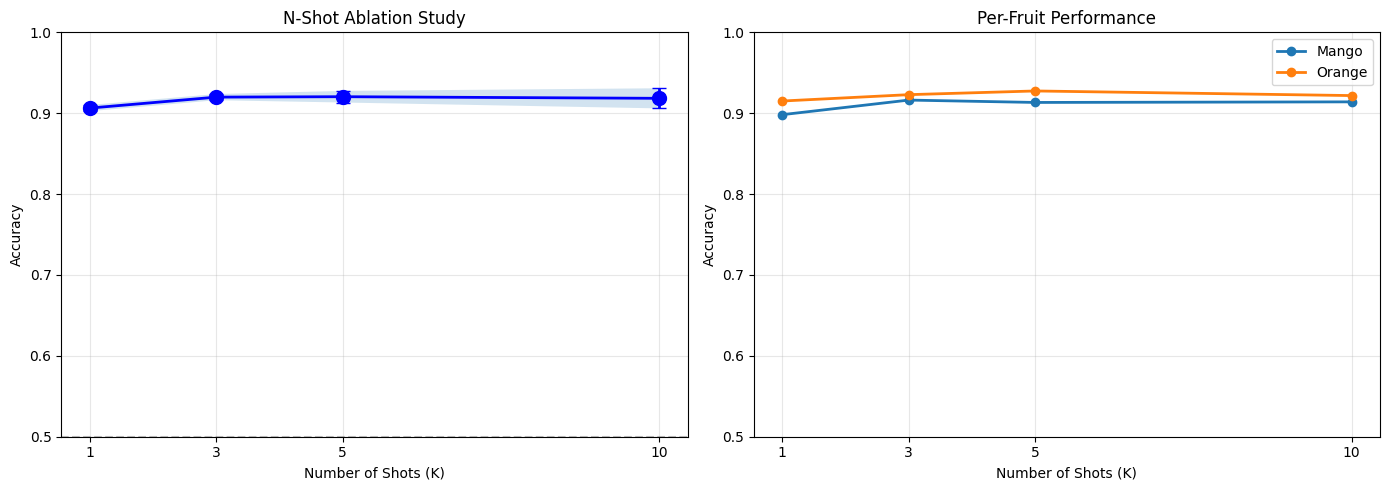


📝 LaTeX Table:
\begin{tabular}{ccc}
K-shot & Accuracy & 95\% CI \\\hline
1 & 90.6\% & $\pm$0.4\% \\
3 & 92.0\% & $\pm$0.4\% \\
5 & 92.0\% & $\pm$0.7\% \\
10 & 91.8\% & $\pm$1.2\% \\
\end{tabular}


In [ ]:
# ============================================================================
# N-SHOT ABLATION STUDY
# ============================================================================

def ablation_n_shot(model, test_dataset, device, config, 
                    shots=[1, 3, 5, 10], n_episodes=300, n_trials=3):
    """Ablation: How does performance change with number of shots?"""
    
    print("=" * 70)
    print("📊 N-SHOT ABLATION STUDY")
    print("=" * 70)
    
    # Load best model
    ckpt_path = os.path.join(config.CHECKPOINT_DIR, 'best_model.pth')
    if os.path.exists(ckpt_path):
        model.load_state_dict(torch.load(ckpt_path, map_location=device)['model_state_dict'])
    
    ablation_results = {}
    
    for n_shot in shots:
        print(f"\nTesting {n_shot}-shot...")
        trial_accs = []
        per_fruit_trials = defaultdict(list)
        
        for trial in range(n_trials):
            loader = EpisodicDataLoader(test_dataset, n_shot, 15, n_episodes)
            acc, per_fruit = evaluate(model, loader, device, f"{n_shot}-shot T{trial+1}")
            trial_accs.append(acc)
            for fruit, f_acc in per_fruit.items():
                per_fruit_trials[fruit].append(f_acc)
        
        mean, std, ci = compute_confidence_interval(trial_accs)
        ablation_results[n_shot] = {
            'mean': mean, 'std': std, 'ci_95': ci,
            'per_fruit': {f: {'mean': np.mean(a), 'std': np.std(a)} 
                         for f, a in per_fruit_trials.items()}
        }
        print(f"  {n_shot}-shot: {mean:.3f} ± {ci:.3f}")
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Overall
    means = [ablation_results[s]['mean'] for s in shots]
    cis = [ablation_results[s]['ci_95'] for s in shots]
    axes[0].errorbar(shots, means, yerr=cis, fmt='bo-', linewidth=2, 
                     markersize=10, capsize=5)
    axes[0].fill_between(shots, [m-c for m,c in zip(means, cis)],
                         [m+c for m,c in zip(means, cis)], alpha=0.2)
    axes[0].set_xlabel('Number of Shots (K)')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('N-Shot Ablation Study')
    axes[0].set_xticks(shots)
    axes[0].set_ylim(0.5, 1.0)
    axes[0].grid(True, alpha=0.3)
    axes[0].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
    
    # Per-fruit
    for fruit in config.TEST_FRUITS:
        fruit_means = [ablation_results[s]['per_fruit'].get(fruit, {}).get('mean', 0) for s in shots]
        axes[1].plot(shots, fruit_means, 'o-', linewidth=2, label=fruit.capitalize())
    axes[1].set_xlabel('Number of Shots (K)')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Per-Fruit Performance')
    axes[1].set_xticks(shots)
    axes[1].set_ylim(0.5, 1.0)
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(config.RESULTS_DIR, 'ablation_nshot.png'), dpi=300)
    plt.show()
    
    # LaTeX table
    print("\n📝 LaTeX Table:")
    print("\\begin{tabular}{ccc}")
    print("K-shot & Accuracy & 95\\% CI \\\\\\hline")
    for s in shots:
        r = ablation_results[s]
        print(f"{s} & {r['mean']*100:.1f}\\% & $\\pm${r['ci_95']*100:.1f}\\% \\\\")
    print("\\end{tabular}")
    
    return ablation_results

# Run ablation
if os.path.exists(config.DATA_ROOT):
    nshot_results = ablation_n_shot(model, test_dataset, device, config)

In [ ]:
# ============================================================================
# BASELINE COMPARISONS WITH CONFIDENCE INTERVALS
# ============================================================================

def evaluate_supervised_baseline(backbone_name, train_dataset, test_dataset, 
                                  device, epochs=15, n_trials=3):
    """
    Train supervised baseline and test on unseen fruits.
    Returns accuracy with confidence intervals for fair comparison.
    """
    
    print(f"\n{'='*60}")
    print(f"BASELINE: Supervised {backbone_name.upper()}")
    print('='*60)
    
    # Simple dataset class
    class SimpleDataset(Dataset):
        def __init__(self, fruit_dataset, transform):
            self.images, self.labels = [], []
            for fruit in fruit_dataset.fruit_types:
                for qi, quality in enumerate(['fresh', 'rotten']):
                    for path in fruit_dataset.data[fruit][quality]:
                        self.images.append(path)
                        self.labels.append(qi)
            self.transform = transform
        
        def __len__(self): return len(self.images)
        
        def __getitem__(self, idx):
            img = Image.open(self.images[idx]).convert('RGB')
            return self.transform(img), self.labels[idx]
    
    trial_accs = []
    
    for trial in range(n_trials):
        set_seed(42 + trial)  # Different seed per trial
        
        # Create model
        if backbone_name == 'densenet121':
            baseline_model = models.densenet121(pretrained=True)
            baseline_model.classifier = nn.Sequential(
                nn.Dropout(0.3), 
                nn.Linear(baseline_model.classifier.in_features, 2)
            )
        elif backbone_name == 'vgg16':
            baseline_model = models.vgg16(pretrained=True)
            baseline_model.classifier[-1] = nn.Linear(4096, 2)
        else:  # resnet18
            baseline_model = models.resnet18(pretrained=True)
            baseline_model.fc = nn.Sequential(
                nn.Dropout(0.3), 
                nn.Linear(baseline_model.fc.in_features, 2)
            )
        
        baseline_model = baseline_model.to(device)
        
        # DataLoaders
        train_ds = SimpleDataset(train_dataset, train_transform)
        test_ds = SimpleDataset(test_dataset, eval_transform)
        train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
        test_dl = DataLoader(test_ds, batch_size=32, num_workers=0)
        
        # Train
        optimizer = torch.optim.Adam(baseline_model.parameters(), lr=1e-4, weight_decay=1e-4)
        ce_criterion = nn.CrossEntropyLoss()
        
        baseline_model.train()
        for epoch in range(epochs):
            for imgs, lbls in tqdm(train_dl, desc=f"Trial {trial+1} Epoch {epoch+1}", leave=False):
                imgs, lbls = imgs.to(device), lbls.to(device)
                optimizer.zero_grad()
                loss = ce_criterion(baseline_model(imgs), lbls)
                loss.backward()
                optimizer.step()
        
        # Test on UNSEEN fruits
        baseline_model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for imgs, lbls in test_dl:
                imgs, lbls = imgs.to(device), lbls.to(device)
                preds = baseline_model(imgs).argmax(1)
                correct += (preds == lbls).sum().item()
                total += lbls.size(0)
        
        acc = correct / total
        trial_accs.append(acc)
        print(f"  Trial {trial+1}: {acc:.3f}")
    
    mean, std, ci = compute_confidence_interval(trial_accs)
    print(f"  Result: {mean:.3f} ± {ci:.3f} (95% CI)")
    
    return {'mean': mean, 'std': std, 'ci_95': ci, 'trials': trial_accs}


def evaluate_clip_baseline(test_dataset, device, n_trials=3):
    """
    Evaluate zero-shot CLIP on unseen fruits.
    CLIP uses text prompts without any training on fruit data.
    """
    
    print(f"\n{'='*60}")
    print("BASELINE: Zero-Shot CLIP")
    print('='*60)
    
    try:
        import clip
    except ImportError:
        print("⚠️ CLIP not installed. Install with: pip install git+https://github.com/openai/CLIP.git")
        print("  Returning placeholder results...")
        return {'mean': 0.5, 'std': 0.0, 'ci_95': 0.0, 'trials': [0.5], 'note': 'CLIP not installed'}
    
    # Load CLIP model
    clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
    clip_model.eval()
    
    # Text prompts for zero-shot classification
    text_prompts = [
        "a photo of a fresh fruit",
        "a photo of a rotten fruit"
    ]
    # Alternative prompts to try
    alt_prompts = [
        ["fresh healthy fruit", "rotten spoiled fruit"],
        ["good quality fruit", "bad quality fruit"],
        ["a fresh fruit with no defects", "a rotten fruit with visible decay"]
    ]
    
    trial_accs = []
    
    for trial, prompts in enumerate([text_prompts] + alt_prompts[:n_trials-1]):
        if trial >= n_trials:
            break
            
        print(f"\n  Trial {trial+1} prompts: {prompts}")
        
        # Tokenize text
        text_tokens = clip.tokenize(prompts).to(device)
        
        with torch.no_grad():
            text_features = clip_model.encode_text(text_tokens)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        
        correct, total = 0, 0
        
        for fruit in test_dataset.fruit_types:
            for class_idx, quality in enumerate(['fresh', 'rotten']):
                images = test_dataset.data[fruit][quality]
                
                for img_path in tqdm(images, desc=f"{fruit}/{quality}", leave=False):
                    img = Image.open(img_path).convert('RGB')
                    img_input = clip_preprocess(img).unsqueeze(0).to(device)
                    
                    with torch.no_grad():
                        image_features = clip_model.encode_image(img_input)
                        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
                        
                        # Compute similarity
                        similarity = (image_features @ text_features.T).softmax(dim=-1)
                        pred = similarity.argmax().item()
                    
                    correct += (pred == class_idx)
                    total += 1
        
        acc = correct / total
        trial_accs.append(acc)
        print(f"    Accuracy: {acc:.3f}")
    
    mean, std, ci = compute_confidence_interval(trial_accs)
    print(f"\n  CLIP Result: {mean:.3f} ± {ci:.3f} (95% CI)")
    
    return {'mean': mean, 'std': std, 'ci_95': ci, 'trials': trial_accs}


def run_all_baselines(train_dataset, test_dataset, device, our_result=None):
    """
    Run all baseline comparisons with proper confidence intervals.
    
    Args:
        train_dataset: Dataset with seen fruits for training baselines
        test_dataset: Dataset with unseen fruits for evaluation
        device: torch device
        our_result: Dictionary with our method's results (from test_on_unseen_fruits)
    """
    
    print("=" * 70)
    print("📊 COMPREHENSIVE BASELINE COMPARISON")
    print("=" * 70)
    print(f"All methods evaluated on UNSEEN fruits: {config.TEST_FRUITS}")
    print(f"Using multiple trials with 95% confidence intervals")
    
    baseline_comparison_results = {}
    
    # Supervised baselines
    for backbone in ['resnet18', 'densenet121', 'vgg16']:
        baseline_comparison_results[f'Supervised {backbone.upper()}'] = evaluate_supervised_baseline(
            backbone, train_dataset, test_dataset, device, epochs=15, n_trials=3
        )
    
    # CLIP baseline (zero-shot)
    baseline_comparison_results['Zero-Shot CLIP'] = evaluate_clip_baseline(test_dataset, device, n_trials=3)
    
    # Add our result if provided
    if our_result is not None:
        baseline_comparison_results['Ours (ProtoNet 5-shot)'] = {
            'mean': our_result['overall']['mean'],
            'std': our_result['overall']['std'],
            'ci_95': our_result['overall']['ci_95']
        }
    
    # Print comparison table
    print("\n" + "=" * 70)
    print("📊 RESULTS COMPARISON TABLE")
    print("=" * 70)
    print(f"\n{'Method':<30} {'Accuracy':>12} {'95% CI':>12}")
    print("-" * 55)
    
    for method, res in baseline_comparison_results.items():
        print(f"{method:<30} {res['mean']:>11.1%} ±{res['ci_95']:>10.1%}")
    
    # Create comparison plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    methods = list(baseline_comparison_results.keys())
    means = [baseline_comparison_results[m]['mean'] for m in methods]
    cis = [baseline_comparison_results[m]['ci_95'] for m in methods]
    
    # Color scheme: blue for baselines, green for ours
    colors = ['#3498db' if 'Ours' not in m else '#2ecc71' for m in methods]
    
    bars = ax.bar(range(len(methods)), means, yerr=cis, capsize=5, 
                  color=colors, edgecolor='black', linewidth=1.5)
    
    ax.set_xticks(range(len(methods)))
    ax.set_xticklabels(methods, rotation=15, ha='right', fontsize=10)
    ax.set_ylabel('Accuracy on Unseen Fruits', fontsize=12)
    ax.set_title('Baseline Comparison: Generalization to Unseen Fruit Species\n(Error bars = 95% CI)', 
                 fontsize=14, fontweight='bold')
    ax.set_ylim(0, 1.1)
    ax.axhline(0.5, color='gray', linestyle='--', alpha=0.5, label='Random Chance')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, mean, ci in zip(bars, means, cis):
        ax.text(bar.get_x() + bar.get_width()/2, mean + ci + 0.02, 
                f'{mean:.1%}', ha='center', fontweight='bold', fontsize=10)
    
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig(os.path.join(config.RESULTS_DIR, 'baseline_comparison.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # LaTeX table
    print("\n📝 LaTeX Table:")
    print("-" * 50)
    print("\\begin{table}[h]")
    print("\\centering")
    print("\\caption{Comparison on Unseen Fruit Species}")
    print("\\begin{tabular}{lcc}")
    print("\\toprule")
    print("Method & Accuracy & 95\\% CI \\\\")
    print("\\midrule")
    for method, res in baseline_comparison_results.items():
        clean_method = method.replace('_', '\\_')
        print(f"{clean_method} & {res['mean']*100:.1f}\\% & $\\pm${res['ci_95']*100:.1f}\\% \\\\")
    print("\\bottomrule")
    print("\\end{tabular}")
    print("\\end{table}")
    
    return baseline_comparison_results


# Run baselines (pass test_results from the previous experiment)
if os.path.exists(config.DATA_ROOT):
    # Get our result from the previous experiment
    our_test_result = test_results if 'test_results' in dir() else None
    baseline_results = run_all_baselines(train_dataset, test_dataset, device, our_test_result)

## 13. Training Curves Visualization

If you need to re-plot the training history after running the training cell.

In [ ]:
# filepath: c:\Users\Amr Samir\Documents\GitHub\Fruit_type_classification\FewShot.ipynb
# ============================================================================
# RE-PLOT TRAINING CURVES (if needed)
# ============================================================================

# Plot if training was run
if 'history' in dir() and history:
    plot_training_history(history, os.path.join(config.RESULTS_DIR, 'training_curves.png'))
else:
    print("⚠️ No training history found. Run training first.")